In [7]:
import os
import gc
import pandas as pd
import numpy as np
from datetime import datetime
from math import ceil
from tqdm import tqdm
from collections import Counter

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, recall_score, accuracy_score, auc, f1_score, matthews_corrcoef, precision_score, precision_recall_curve, confusion_matrix

import tensorflow as tf
#tf.enable_eager_execution()
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential, optimizers
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import LSTM, Dense, Activation, Dropout, Input, GRU
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import AUC
from tensorflow.keras.backend import clear_session
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical

from tensorflow.compat.v1.keras.layers import LSTM

seed = 8888
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.set_random_seed(seed)

to_save = {}
to_save['random_seed'] = seed

In [9]:
def find_optimal_cutoff(TPRs, FPRs, thresholds):
    """
    Find the optimal classification threshold, where the distance between TPR and FPR is maximum
    :param TPRs: TPR values at different thresholds
    :param FPRs: FPR values at different thresholds
    :param thresholds: Different classification thresholds
    :return: optimal classification threshold, (optimal TPR, optimal FPR)
    """
    distance = TPRs - FPRs
    idx = np.argmax(distance)  # Only the first occurrence is returned.
    optimal_threshold = thresholds[idx]
    optimal_point = (TPRs[idx], FPRs[idx])
    
    return optimal_threshold, optimal_point


def roc_values(y_true, y_proba):
    """
    Get FPRs, TPRs, AUC value, optimal classification threshold, optimal TPR and optimal FPR of ROC curve
    :param y_true: True values list of sample labels
    :param y_proba: Model-predicted probability of AKI
    :return: FPRs, TPRs, AUC value, optimal classification threshold, (optimal TPR, optimal FPR)
    """
    fprs, tprs, thresholds = roc_curve(y_true, y_proba, pos_label=1)
    roc_auc = auc(fprs, tprs)
    optimal_threshold, optimal_point = find_optimal_cutoff(TPRs=tprs, FPRs=fprs, thresholds=thresholds)
    
    return fprs, tprs, roc_auc, optimal_threshold, optimal_point


def get_set(id_list, id_col, time_col, data):
    """
    Get patient data for the specified ID list
    :param id_col: Name of ID column
    :param time_col: Name of timestamp column
    :param data: DataFrame of patient data
    :return: Patient data for the specified ID list
    """
    data = data[data[id_col].isin(id_list)].sort_values(by=[id_col, time_col], ascending=True)
    data.reset_index(drop=True, inplace=True)
    
    return data


def performance(label, proba, pred):
    """
    Get model evaluation metrics
    :param label: True values list of sample labels
    :param proba: Model-predicted probability of AKI
    :param pred: Predicted values under the optimal classification threshold
    :return: Accuracy, Recall, MCC, Precision, F1-score, AUC, FPR
    """
    acc = accuracy_score(label, pred)
    recall = recall_score(label, pred, pos_label=1)
    mcc = matthews_corrcoef(label, pred)
    precision = precision_score(label, pred)
    f1 = f1_score(label, pred)
    roc_auc = roc_auc_score(label, proba)
    tn, fp, fn, tp = confusion_matrix(label, pred).ravel()
    fpr = fp/(fp+tn)
    
    print(f'accuracy: {acc:.4f}')
    print(f'recall: {recall:.4f}')
    print(f'AUC: {roc_auc:.4f}')
    print(f'MCC: {mcc:.4f}')
    print(f'precision: {precision:.4f}')
    print(f'F1: {f1:.4f}')
    print(f'FPR: {fpr:.4f}')
    
    return acc, recall, mcc, precision, f1, roc_auc, fpr

ERROR! Session/line number was not unique in database. History logging moved to new session 837


In [10]:
BATCH_SIZE = 16
EPOCHS = 5

# Imputing(feature and label)
FILL_WITH_ZERO = True
FILL_VALUE = 0

LABEL_COLUMN = 'aki_stage'
# Resample interval
RSMP = 6
# Advance prediction time
SFT = 48
# FEATURE_SET = 'SCr_lab_vit_dem_med_pro'

DATA_PATH = f'./data_con_eICU.tsv'
MODEL_SAVE_PATH = './DC-AKI_eICU.h5'
TEST_RESULT_PATH = f'./predict_result/DC-AKI_eICU_continuous.csv'
TRAINING_PARAM_PATH = './result.xls'

to_save['batch_size'] = BATCH_SIZE
to_save['epoch'] = EPOCHS
to_save['imputation'] = 'fill with zero'
to_save['resample_interval'] = RSMP
to_save['prediction_ahead'] = SFT
to_save['data_dev_path'] = DATA_PATH
to_save['data_external_path'] = DATA_EXTERNAL_PATH
to_save['model_path'] = MODEL_SAVE_PATH
to_save['test_result_path'] = TEST_RESULT_PATH
to_save['external_result_path'] = EXTERNAL_RESULT_PATH

In [11]:
data_ori = pd.read_csv(DATA_PATH, sep='\t')
if 'patient_id' in data_ori.columns:
    data_ori.rename(columns={'patient_id': 'stay_id', '检验日期': 'charttime'}, inplace=True)
id_col, time_col = 'stay_id', 'charttime'
print(f'Sample num: {data_ori.stay_id.nunique()}')
data_ori.shape

Sample num: 19799


(867140, 33)

In [12]:
data_ori.head()

,stay_id,charttime,akistage,index,heartrate,sao2,ptt,pt,bun,age,...,unitadmitsource_Acute Care/Floor,unitadmitsource_Chest Pain Center,unitadmitsource_Direct Admit,unitadmitsource_Emergency Department,unitadmitsource_Floor,unitadmitsource_ICU,unitadmitsource_Observation,unitadmitsource_Other,unitadmitsource_Room,unitadmitsource_Step-Down Unit (SDU)
0,141244,0 days 01:26:00,0.0,0,99.0,965.0,NaN,NaN,NaN,59.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,141244,0 days 01:28:00,0.0,1,95.0,2580.0,NaN,NaN,NaN,59.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,141244,0 days 01:30:00,0.0,2,95.0,2565.0,NaN,NaN,NaN,59.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,141244,0 days 01:32:00,0.0,3,98.0,2625.0,NaN,NaN,NaN,59.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,141244,0 days 01:34:00,0.0,4,95.0,3380.0,NaN,NaN,NaN,59.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [13]:
data_ori.columns

Index(['stay_id', 'charttime', 'akistage', 'index', 'heartrate', 'sao2', 'ptt',
       'pt', 'bun', 'age', 'hospitaladmitoffset', 'gender_Female',
       'gender_Male', 'gender_Unknown', 'ethnicity_',
       'ethnicity_African American', 'ethnicity_Asian', 'ethnicity_Caucasian',
       'ethnicity_Hispanic', 'ethnicity_Native American',
       'ethnicity_Other/Unknown', 'unitadmitsource_', 'unitadmitsource_ACU',
       'unitadmitsource_Acute Care/Floor', 'unitadmitsource_Chest Pain Center',
       'unitadmitsource_Direct Admit', 'unitadmitsource_Emergency Department',
       'unitadmitsource_Floor', 'unitadmitsource_ICU',
       'unitadmitsource_Observation', 'unitadmitsource_Other',
       'unitadmitsource_Room', 'unitadmitsource_Step-Down Unit (SDU)'],
      dtype='object')

In [14]:
data_ori = data_ori.rename(columns={'akistage': 'aki_stage'})

In [15]:
others = [id_col, time_col, LABEL_COLUMN]

In [16]:
data = data_ori.copy()
# Label imputing
data[LABEL_COLUMN].fillna(FILL_VALUE, inplace=True)
data[LABEL_COLUMN] = data.groupby(id_col)[LABEL_COLUMN].shift(-(SFT/RSMP))
data.dropna(subset=[LABEL_COLUMN], how='all', inplace=True)
data[LABEL_COLUMN].replace([2, 3], [1, 1], inplace=True)
    
print(f'Sample_num: {data[id_col].nunique()}')
print(f'AKI_label: {data[LABEL_COLUMN].unique()}')
data.shape

Sample_num: 17482
AKI_label: [0. 1.]


(715739, 33)

In [17]:
positive_samples = data[data['aki_stage'] == 1]
negative_samples = data[data['aki_stage'] == 0]

undersampled_negative = negative_samples.sample(n=100, replace=False, random_state=42)
undersampled_data = pd.concat([positive_samples, undersampled_negative], axis=0)

# 打乱数据，确保随机性
undersampled = undersampled_data.sample(frac=1, random_state=42).reset_index(drop=True)
data = undersampled.copy()

In [18]:
aki = data[[id_col, LABEL_COLUMN]].copy()
aki = aki.groupby([id_col]).max()
c = Counter(aki[LABEL_COLUMN].values)
print(f'标签数量统计: {c}')
print(f'AKI病人占比: {c[1]/len(aki):.4f}')
to_save['AKI_ratio'] = c[1]/len(aki)

标签数量统计: Counter({0.0: 99, 1.0: 38})
AKI病人占比: 0.2774


In [19]:
#data.charttime = pd.to_datetime(data.charttime)
data.sort_values(by=[id_col, time_col], ascending=True, inplace=True)
data.reset_index(drop=True, inplace=True)

In [20]:
new_column_order = [col for col in data.columns if col != 'aki_stage'] + ['aki_stage']
data = data[new_column_order]

In [21]:
column_order = data.columns.tolist()
print(column_order)

['stay_id', 'charttime', 'index', 'heartrate', 'sao2', 'ptt', 'pt', 'bun', 'age', 'hospitaladmitoffset', 'gender_Female', 'gender_Male', 'gender_Unknown', 'ethnicity_', 'ethnicity_African American', 'ethnicity_Asian', 'ethnicity_Caucasian', 'ethnicity_Hispanic', 'ethnicity_Native American', 'ethnicity_Other/Unknown', 'unitadmitsource_', 'unitadmitsource_ACU', 'unitadmitsource_Acute Care/Floor', 'unitadmitsource_Chest Pain Center', 'unitadmitsource_Direct Admit', 'unitadmitsource_Emergency Department', 'unitadmitsource_Floor', 'unitadmitsource_ICU', 'unitadmitsource_Observation', 'unitadmitsource_Other', 'unitadmitsource_Room', 'unitadmitsource_Step-Down Unit (SDU)', 'aki_stage']


In [22]:
data.drop(columns=['hospitaladmitoffset','index'], inplace=True)

In [28]:
icustays = data.stay_id.unique().tolist()
features = data.columns.difference(others).tolist()

print(f'Sample num: {len(icustays)}, Feature num: {len(features)}\n')
print(f'features: {features}')

to_save['sample_num'] = len(icustays)
to_save['feature_num'] = len(features)

Sample num: 137, Feature num: 28

features: ['age', 'bun', 'ethnicity_', 'ethnicity_African American', 'ethnicity_Asian', 'ethnicity_Caucasian', 'ethnicity_Hispanic', 'ethnicity_Native American', 'ethnicity_Other/Unknown', 'gender_Female', 'gender_Male', 'gender_Unknown', 'heartrate', 'pt', 'ptt', 'sao2', 'unitadmitsource_', 'unitadmitsource_ACU', 'unitadmitsource_Acute Care/Floor', 'unitadmitsource_Chest Pain Center', 'unitadmitsource_Direct Admit', 'unitadmitsource_Emergency Department', 'unitadmitsource_Floor', 'unitadmitsource_ICU', 'unitadmitsource_Observation', 'unitadmitsource_Other', 'unitadmitsource_Room', 'unitadmitsource_Step-Down Unit (SDU)']


In [ ]:
columns_to_drop = ['index', 'hospitaladmitoffset']
data.drop(columns=columns_to_drop, inplace=True)
features.remove('index')

In [ ]:
features.remove('hospitaladmitoffset')

In [24]:
data.columns

Index(['stay_id', 'charttime', 'heartrate', 'sao2', 'ptt', 'pt', 'bun', 'age',
       'gender_Female', 'gender_Male', 'gender_Unknown', 'ethnicity_',
       'ethnicity_African American', 'ethnicity_Asian', 'ethnicity_Caucasian',
       'ethnicity_Hispanic', 'ethnicity_Native American',
       'ethnicity_Other/Unknown', 'unitadmitsource_', 'unitadmitsource_ACU',
       'unitadmitsource_Acute Care/Floor', 'unitadmitsource_Chest Pain Center',
       'unitadmitsource_Direct Admit', 'unitadmitsource_Emergency Department',
       'unitadmitsource_Floor', 'unitadmitsource_ICU',
       'unitadmitsource_Observation', 'unitadmitsource_Other',
       'unitadmitsource_Room', 'unitadmitsource_Step-Down Unit (SDU)',
       'aki_stage'],
      dtype='object')

ERROR! Session/line number was not unique in database. History logging moved to new session 838


In [25]:
data.head()

,stay_id,charttime,heartrate,sao2,ptt,pt,bun,age,gender_Female,gender_Male,...,unitadmitsource_Chest Pain Center,unitadmitsource_Direct Admit,unitadmitsource_Emergency Department,unitadmitsource_Floor,unitadmitsource_ICU,unitadmitsource_Observation,unitadmitsource_Other,unitadmitsource_Room,unitadmitsource_Step-Down Unit (SDU),aki_stage
0,153993,0 days 02:02:00,98.0,916.0,NaN,NaN,NaN,59.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,162778,0 days 01:46:00,100.0,2898.0,NaN,NaN,NaN,59.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,181698,13 days 12:11:00,NaN,NaN,59.0,NaN,NaN,60.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,183795,0 days 01:00:00,96.0,182.0,NaN,NaN,NaN,72.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,188576,0 days 01:11:00,96.0,119.0,NaN,NaN,NaN,89.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


# Imputing

In [26]:
features=['unitadmitsource_Step-Down Unit (SDU)',
          'gender_Female','sao2',
          'ethnicity_Native American',
          'ethnicity_African American','gender_Male','unitadmitsource_ICU','ethnicity_Other/Unknown',
          'age','bun']

In [29]:
print('Imputing with zero!')
data.fillna(FILL_VALUE, inplace=True)

Imputing with zero!


# Train/Validation/Test set

In [30]:
train_id, val_test_id = train_test_split(icustays, test_size=0.2, random_state=seed)
val_id, test_id = train_test_split(val_test_id, test_size=0.5, random_state=seed)
print(f'Train samples: {len(train_id)}\nValidation samples: {len(val_id)}\nTest samples: {len(test_id)}')

Train samples: 109
Validation samples: 14
Test samples: 14


In [31]:
train = get_set(id_list=train_id, id_col=id_col, time_col=time_col, data=data)
val = get_set(val_id, id_col, time_col, data)
test = get_set(test_id, id_col, time_col, data)

train.shape, val.shape, test.shape

((110, 31), (14, 31), (14, 31))

In [32]:
# 各集合中AKI病人占比
aki_train = train[[id_col, LABEL_COLUMN]].copy().groupby([id_col]).max()
aki_val = val[[id_col, LABEL_COLUMN]].copy().groupby([id_col]).max()
aki_test = test[[id_col, LABEL_COLUMN]].copy().groupby([id_col]).max()

print(f'train: {aki_train.aki_stage.sum()/len(aki_train):.4f}')
print(f'val: {aki_val.aki_stage.sum()/len(aki_val):.4f}')      
print(f'test: {aki_test.aki_stage.sum()/len(aki_test):.4f}')

train: 0.2844
val: 0.2857
test: 0.2143


# Split features and label / Normalization

In [33]:
train.sort_values(by=[id_col, time_col], ascending=True, inplace=True)
val.sort_values(by=[id_col, time_col], ascending=True, inplace=True)
test.sort_values(by=[id_col, time_col], ascending=True, inplace=True)

In [34]:
train = train[others+features].copy()
val = val[others+features].copy()
test = test[others+features].copy()

In [35]:
train_list = [train[train[id_col]==i].iloc[:, 2:].values for i in train_id]
val_list = [val[val[id_col]==i].iloc[:, 2:].values for i in val_id]
test_list = [test[test[id_col]==i].iloc[:, 2:].values for i in test_id]

In [36]:
# 将训练集中最长的时间序列长度设置为模型最长时间步
maxlen = train.groupby('stay_id').size().max()
to_save['time_seq_length'] = maxlen
maxlen

2

In [37]:
train_data = pad_sequences(
    train_list, 
    dtype='float32', 
    padding='pre', 
    truncating='pre', 
    value=0, 
    maxlen=maxlen
)
val_data = pad_sequences(
    val_list, 
    dtype='float32', 
    padding='pre', 
    truncating='pre', 
    value=0, 
    maxlen=maxlen
)
test_data = pad_sequences(
    test_list, 
    dtype='float32', 
    padding='pre', 
    truncating='pre', 
    value=0, 
    maxlen=maxlen
)
train_data.shape, val_data.shape, test_data.shape

((109, 2, 29), (14, 2, 29), (14, 2, 29))

In [38]:
# 将特征和标签分离
train_label = train_data[:, :, 0]
val_label = val_data[:, :, 0]
test_label = test_data[:, :, 0]

train_data = train_data[:, :, 1:]
val_data = val_data[:, :, 1:]
test_data = test_data[:, :, 1:]

In [39]:
# feature normalization
train_data = train_data.reshape(-1, len(features))
val_data = val_data.reshape(-1, len(features))
test_data = test_data.reshape(-1, len(features))

feature_scaler = StandardScaler()
feature_scaler.fit(train_data)

train_data = feature_scaler.transform(train_data)
train_data = train_data.reshape(-1, maxlen, len(features))

val_data = feature_scaler.transform(val_data)
val_data = val_data.reshape(-1, maxlen, len(features))

test_data = feature_scaler.transform(test_data)
test_data = test_data.reshape(-1, maxlen, len(features))

train_data.shape, val_data.shape, test_data.shape

((109, 2, 28), (14, 2, 28), (14, 2, 28))

In [40]:
# label one-hot
train_label = train_label.reshape(-1, maxlen, 1)
val_label = val_label.reshape(-1, maxlen, 1)
test_label = test_label.reshape(-1, maxlen, 1)

train_label = to_categorical(train_label)
val_label = to_categorical(val_label)
test_label = to_categorical(test_label)

train_label.shape, val_label.shape, test_label.shape

((109, 2, 2), (14, 2, 2), (14, 2, 2))

# DC-AKI(base)

In [1]:
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, GRU, Bidirectional, Dense, Dropout, Attention
def get_model(max_len, feature_num):
    
    clear_session()
    inputs = Input(shape=(max_len, feature_num), dtype='float32')
    x = Dense(64, activation='relu')(inputs)
    outputs = Dense(2, activation='sigmoid')(x)

    model = Model(inputs, outputs)
    model.summary()
    
    return model

In [ ]:
model = get_model(max_len=maxlen, feature_num=len(features))

In [82]:
adam = optimizers.Adam(lr=0.001)
loss = BinaryCrossentropy(from_logits=False)
k_auc = AUC()

checkpoint = ModelCheckpoint(
    MODEL_SAVE_PATH, 
    monitor='val_auc', 
    mode='max', 
    save_best_only=True
)

model.compile(
    optimizer=adam, 
    loss=loss,
    metrics=[k_auc]
)

to_save['lr'] = 0.001

In [83]:
time_start = datetime.now()
history = model.fit(
    train_data, train_label,
    validation_data=(val_data, val_label), 
    batch_size=16, 
    epochs=5, 
    callbacks=[checkpoint])
train_time = (datetime.now() - time_start).total_seconds()
to_save['train_time'] = train_time
print(train_time)

Train on 109 samples, validate on 14 samples
Epoch 1/5
109/109 [==============================] - 1s 6ms/sample - loss: 0.6176 - auc: 0.8283 - val_loss: 0.5882 - val_auc: 0.9126
Epoch 2/5
109/109 [==============================] - 0s 260us/sample - loss: 0.5946 - auc: 0.8510 - val_loss: 0.5693 - val_auc: 0.9107
Epoch 3/5
109/109 [==============================] - 0s 256us/sample - loss: 0.5755 - auc: 0.8636 - val_loss: 0.5498 - val_auc: 0.9101
Epoch 4/5
109/109 [==============================] - 0s 238us/sample - loss: 0.5555 - auc: 0.8770 - val_loss: 0.5314 - val_auc: 0.9120
Epoch 5/5
109/109 [==============================] - 0s 459us/sample - loss: 0.5370 - auc: 0.8874 - val_loss: 0.5140 - val_auc: 0.9139
1.492318


In [84]:
test_BASE = model.predict(test_data)
from sklearn.metrics import roc_auc_score

# 将三维数组转换为一维数组
reshaped_test_BASE = test_BASE.flatten()
reshaped_true_label = test_label.flatten()

# 计算 ROC AUC
roc_auc = roc_auc_score(reshaped_true_label, reshaped_test_BASE)
print(f"ROC AUC: {roc_auc}")

ROC AUC: 0.9081632653061225


In [86]:
from sklearn.metrics import precision_recall_curve, auc,f1_score
precision_BASE, recall_BASE, thresholds = precision_recall_curve(reshaped_true_label, reshaped_test_BASE)
# 计算 PR AUC
pr_auc_BASE = auc(recall_BASE, precision_BASE)


print("PR AUC:", pr_auc_BASE)
threshold = 0.5
reshaped_test_BASE = (reshaped_test_BASE > threshold).astype(int)
f1 = f1_score(reshaped_true_label, reshaped_test_BASE)
print(f1)

PR AUC: 0.8787243360529167
0.8474576271186439


In [35]:
test_result.to_csv(TEST_RESULT_PATH, index=False)

# DC-AKI

In [41]:
from tensorflow.keras.layers import Input, Flatten, Conv1D, MaxPooling1D, GRU, Bidirectional, Dense, Dropout, Concatenate, Activation, GlobalMaxPooling1D, Multiply, Add
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Reshape
def get_model(max_len, feature_num):
    x = Input(shape=(max_len, feature_num), dtype='float32')
    x1 = Dense(64, activation='relu')(x)
    x1 = GRU(32, return_sequences=True)(x1)
    x1 = Dropout(0.5)(x1)
    x1 = GRU(32, return_sequences=True)(x1)
    x1 = Dropout(0.5)(x1)
    attention = Dense(32, activation='tanh')(x1)
    attention = Flatten()(attention)
    attention = Activation('sigmoid')(attention)
    attention_reshaped = Reshape((max_len, 32))(attention)
    
    # Multiply and Add layers for element-wise multiplication and addition
    attention_mult = Multiply()([x1, attention_reshaped])
    attention_sum = Add()([x1, attention_reshaped])
    
    y2 = Dense(64, activation='relu')(x)
    y2 = Conv1D(filters=128, kernel_size=3, padding='same')(y2)
    y2 = Dropout(0.5)(y2)
    #y2 = GlobalMaxPooling1D()(y2)
    y2 = Dense(64, activation='relu')(y2)
    concatenated = Concatenate()([attention_mult, attention_sum, y2])
    concatenated = Dense(32, activation='relu')(concatenated)
    outputs = Dense(2, activation='sigmoid')(concatenated)
    
    model = Model(inputs=x, outputs=outputs)
    model.summary()
    
    return model


ERROR! Session/line number was not unique in database. History logging moved to new session 839


In [42]:
model_our = get_model(max_len=maxlen, feature_num=len(features))

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2, 28)]      0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 2, 64)        1856        input_1[0][0]                    
__________________________________________________________________________________________________
gru (GRU)                       (None, 2, 32)        9312        dense[0][0]                      
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2, 32)        0           gru[0][0]                        
______________________________________________________________________________________________

In [43]:
adam = optimizers.Adam(lr=0.001)
loss = BinaryCrossentropy(from_logits=False)
k_auc = AUC()

checkpoint = ModelCheckpoint(
    MODEL_SAVE_PATH, 
    monitor='val_auc', 
    mode='max', 
    save_best_only=True
)

model_our.compile(
    optimizer=adam, 
    loss=loss,
    metrics=[k_auc]
)

to_save['lr'] = 0.001

In [44]:
time_start = datetime.now()
history = model_our.fit(
    train_data, train_label,
    validation_data=(val_data, val_label), 
    batch_size=16, 
    epochs=5, 
    callbacks=[checkpoint])
train_time = (datetime.now() - time_start).total_seconds()
to_save['train_time'] = train_time
print(train_time)

Train on 109 samples, validate on 14 samples
Epoch 1/5
109/109 [==============================] - 7s 68ms/sample - loss: 0.5883 - auc: 0.8464 - val_loss: 0.4693 - val_auc: 0.8986
Epoch 2/5
109/109 [==============================] - 0s 2ms/sample - loss: 0.4005 - auc: 0.9163 - val_loss: 0.3563 - val_auc: 0.9343
Epoch 3/5
109/109 [==============================] - 0s 2ms/sample - loss: 0.3311 - auc: 0.9392 - val_loss: 0.3129 - val_auc: 0.9445
Epoch 4/5
109/109 [==============================] - 0s 2ms/sample - loss: 0.2968 - auc: 0.9519 - val_loss: 0.2859 - val_auc: 0.9483
Epoch 5/5
109/109 [==============================] - 0s 2ms/sample - loss: 0.2736 - auc: 0.9531 - val_loss: 0.2718 - val_auc: 0.9522
14.845942


In [ ]:
from sklearn.model_selection import train_test_split, GroupKFold, KFold
from tensorflow import keras
from tqdm import tqdm

COMPUTE_LSTM_IMPORTANCE = 1
ONE_FOLD_ONLY = 1
NUM_FOLDS = 28
COLS = (['age', 'bun', 'ethnicity_', 'ethnicity_African American', 'ethnicity_Asian', 'ethnicity_Caucasian',
         'ethnicity_Hispanic', 'ethnicity_Native American', 'ethnicity_Other/Unknown', 'gender_Female',
         'gender_Male', 'gender_Unknown', 'heartrate', 'pt', 'ptt', 'sao2', 'unitadmitsource_', 'unitadmitsource_ACU',
         'unitadmitsource_Acute Care/Floor', 'unitadmitsource_Chest Pain Center', 'unitadmitsource_Direct Admit',
         'unitadmitsource_Emergency Department', 'unitadmitsource_Floor', 'unitadmitsource_ICU',
         'unitadmitsource_Observation', 'unitadmitsource_Other', 'unitadmitsource_Room',
         'unitadmitsource_Step-Down Unit (SDU)'])

import matplotlib.pyplot as plt
model = keras.models.load_model('./GRU24.h5')
        # 计算特征重要性
if COMPUTE_LSTM_IMPORTANCE:
            results = []
            print(' Computing GRU feature importance...')
            

            for k in tqdm(range(28)):
                save_col = train_data[:,:,k].copy()
                np.random.shuffle(train_data[:,:,k])
                oof_preds = model.predict(train_data, verbose=0).squeeze() 
                mae = np.mean(np.abs( oof_preds-train_label))
                results.append({'feature':COLS[k],'mae':mae})
                train_data[:,:,k] = save_col
            print()
            df = pd.DataFrame(results)
            df = df.sort_values('mae')
            plt.figure(figsize=(10,10))
            plt.barh(np.arange(len(COLS)+1),df.mae)
            plt.yticks(np.arange(len(COLS)+1),df.feature.values)
            plt.title('GRU Feature Importance',size=12)
            plt.ylim((-1,len(COLS)+1))
            plt.xlim((0.15, max(df.mae) + 0.1))  # 添加这行代码
            plt.show()
                               
            # SAVE LSTM FEATURE IMPORTANCE
            df = df.sort_values('mae',ascending=False)
            df.to_csv(f'feature_importance_fold12_48.csv',index=False)
                               
        # ONLY DO ONE FOLD
#if ONE_FOLD_ONLY: break

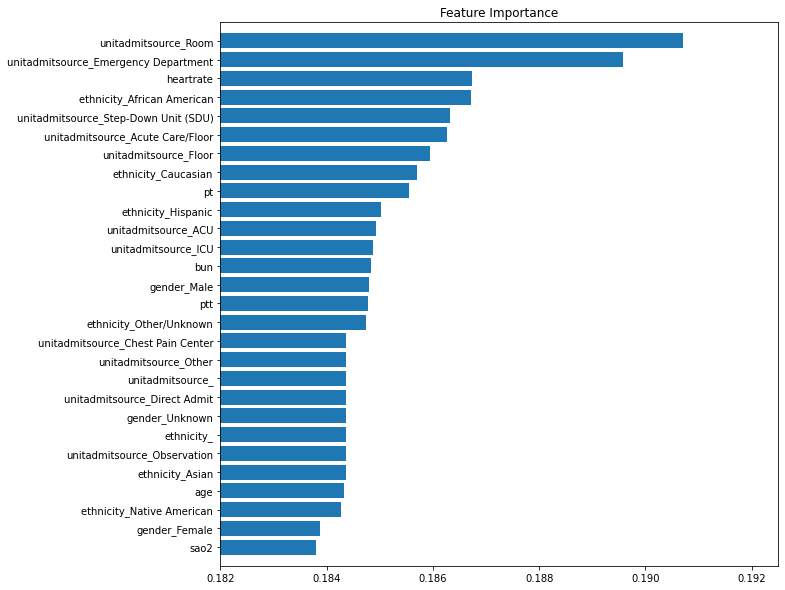

In [52]:
            print()
            df = pd.DataFrame(results)
            df = df.sort_values('mae')
            plt.figure(figsize=(10,10))
            plt.barh(np.arange(28),df.mae)
            plt.yticks(np.arange(28),df.feature.values)
            plt.title('Feature Importance',size=12)
            plt.ylim((-1,28))
            plt.xlim((0.1820, 0.1925))  # 添加这行代码
            plt.show()
                               
            # SAVE LSTM FEATURE IMPORTANCE
            df = df.sort_values('mae',ascending=False)
            df.to_csv(f'GRU_feature_importance_fold12_48.csv',index=False)
                               

In [91]:
test_our = model_our.predict(test_data)
from sklearn.metrics import roc_auc_score

# 将三维数组转换为一维数组
reshaped_test_our = test_our.flatten()
reshaped_true_label = test_label.flatten()

# 计算 ROC AUC
roc_auc_our = roc_auc_score(reshaped_true_label, reshaped_test_our)
print(f"ROC AUC: {roc_auc_our}")

ROC AUC: 0.9604591836734694


In [92]:
fpr_our, tpr_our, thresholds_our = roc_curve(reshaped_true_label, reshaped_test_our)
roc_auc_our = auc(fpr_our, tpr_our)
print(roc_auc_our)

0.9604591836734694


In [93]:
roc_auc_our = roc_auc_score(reshaped_true_label, reshaped_test_our)
print(f"ROC AUC: {roc_auc_our}")

ROC AUC: 0.9604591836734694


In [94]:
from sklearn.metrics import precision_recall_curve, auc,f1_score
precision_our, recall_our, thresholds = precision_recall_curve(reshaped_true_label, reshaped_test_our)
# 计算 PR AUC
pr_auc_our= auc(recall_our, precision_our)
print("PR AUC:", pr_auc_our)
threshold = 0.5
reshaped_test_our = (reshaped_test_our > threshold).astype(int)
f1 = f1_score(reshaped_true_label, reshaped_test_our)
print(f1)

PR AUC: 0.9623602039462463
0.8928571428571429


# DC-AKI(GRU)

In [142]:
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, GRU, Bidirectional, Dense, Dropout, Attention
def get_model(max_len, feature_num):
    
    clear_session()
    inputs = Input(shape=(max_len, feature_num), dtype='float32')
    x1 = Dense(64, activation='relu')(inputs)
    x1 = GRU(64, return_sequences=True)(x1)
    x1 = Dropout(0.5)(x1)
    attention = Dense(64, activation='tanh')(x1)
    attention = Flatten()(attention)
    attention = Activation('sigmoid')(attention)
    attention_reshaped = Reshape((max_len, 64))(attention)
    attention_mult = Multiply()([x1, attention_reshaped])
    attention_sum = Add()([x1, attention_reshaped])
    outputs = Dense(2, activation='sigmoid')(attention_sum)

    model = Model(inputs, outputs)
    model.summary()
    
    return model

In [134]:
model_GRU = get_model(max_len=maxlen, feature_num=len(features))

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2, 30)]      0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 2, 64)        1984        input_1[0][0]                    
__________________________________________________________________________________________________
gru (GRU)                       (None, 2, 64)        24768       dense[0][0]                      
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2, 64)        0           gru[0][0]                        
______________________________________________________________________________________________

In [135]:
adam = optimizers.Adam(lr=0.001)
loss = BinaryCrossentropy(from_logits=False)
k_auc = AUC()

checkpoint = ModelCheckpoint(
    MODEL_SAVE_PATH, 
    monitor='val_auc', 
    mode='max', 
    save_best_only=True
)

model_GRU.compile(
    optimizer=adam, 
    loss=loss,
    metrics=[k_auc]
)

to_save['lr'] = 0.001

In [136]:
time_start = datetime.now()
history = model_GRU.fit(
    train_data, train_label,
    validation_data=(val_data, val_label), 
    batch_size=16, 
    epochs=5, 
    callbacks=[checkpoint])
train_time = (datetime.now() - time_start).total_seconds()
to_save['train_time'] = train_time
print(train_time)

Train on 109 samples, validate on 14 samples
Epoch 1/5
109/109 [==============================] - 1s 10ms/sample - loss: 0.9903 - auc: 0.1407 - val_loss: 0.8296 - val_auc: 0.1193
Epoch 2/5
109/109 [==============================] - 0s 545us/sample - loss: 0.7408 - auc: 0.3592 - val_loss: 0.6313 - val_auc: 0.7953
Epoch 3/5
109/109 [==============================] - 0s 451us/sample - loss: 0.5826 - auc: 0.8114 - val_loss: 0.5257 - val_auc: 0.7997
Epoch 4/5
109/109 [==============================] - 0s 276us/sample - loss: 0.5014 - auc: 0.8126 - val_loss: 0.4731 - val_auc: 0.7972
Epoch 5/5
109/109 [==============================] - 0s 633us/sample - loss: 0.4373 - auc: 0.8530 - val_loss: 0.4361 - val_auc: 0.8482
2.462366


In [137]:
test_GRU = model_GRU.predict(test_data)
from sklearn.metrics import roc_auc_score

# 将三维数组转换为一维数组
reshaped_test_GRU = test_GRU.flatten()
#reshaped_true_label = true_label.flatten()

# 计算 ROC AUC
roc_auc_GRU = roc_auc_score(reshaped_true_label, reshaped_test_GRU)
print(f"ROC AUC: {roc_auc_GRU}")

ERROR! Session/line number was not unique in database. History logging moved to new session 753
ROC AUC: 0.8558673469387755


In [138]:
from sklearn.metrics import precision_recall_curve, auc,f1_score
precision_GRU, recall_GRU, thresholds = precision_recall_curve(reshaped_true_label, reshaped_test_GRU)
# 计算 PR AUC
pr_auc_GRU1 = auc(recall_GRU, precision_GRU)
print("PR AUC:", pr_auc_GRU)
threshold = 0.5
reshaped_test_GRU = (reshaped_test_GRU > threshold).astype(int)
f1 = f1_score(reshaped_true_label, reshaped_test_GRU)
print(f1)

PR AUC: 0.7952287362261029
0.8928571428571429


# DA-AKI(CNN)

In [147]:
from tensorflow.keras.layers import Input,Flatten, Conv1D, MaxPooling1D, GRU, Bidirectional, Dense, Dropout, Concatenate, Activation, Dot,GlobalMaxPooling1D,SimpleRNN

def get_model(max_len, feature_num):
    x = Input(shape=(max_len, feature_num), dtype='float32')
    y2 = Conv1D(filters=64, kernel_size=3, padding='same')(x)
    y2 = Dropout(0.5)(y2)
   # y2 = Dense(64, activation='relu')(y2)
    outputs = Dense(2, activation='sigmoid')(y2)
    
    model = Model(inputs=x, outputs=outputs)
    model.summary()
    
    return model

In [148]:
model_CNN = get_model(max_len=maxlen, feature_num=len(features))

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2, 30)]           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 2, 64)             5824      
_________________________________________________________________
dropout_2 (Dropout)          (None, 2, 64)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 2, 2)              130       
Total params: 5,954
Trainable params: 5,954
Non-trainable params: 0
_________________________________________________________________


In [149]:
adam = optimizers.Adam(lr=0.001)
loss = BinaryCrossentropy(from_logits=False)
k_auc = AUC()

checkpoint = ModelCheckpoint(
    MODEL_SAVE_PATH, 
    monitor='val_auc', 
    mode='max', 
    save_best_only=True
)

model_CNN.compile(
    optimizer=adam, 
    loss=loss,
    metrics=[k_auc]
)

to_save['lr'] = 0.001

In [150]:
time_start = datetime.now()
history = model_CNN.fit(
    train_data, train_label,
    validation_data=(val_data, val_label), 
    batch_size=16, 
    epochs=5, 
    callbacks=[checkpoint])
train_time = (datetime.now() - time_start).total_seconds()
to_save['train_time'] = train_time
print(train_time)

Train on 109 samples, validate on 14 samples
Epoch 1/5
 16/109 [===>..........................] - ETA: 0s - loss: 0.7018 - auc_1: 0.5903WARNING:tensorflow:Can save best model only with val_auc available, skipping.


109/109 [==============================] - 0s 3ms/sample - loss: 0.8202 - auc_1: 0.5290 - val_loss: 0.5917 - val_auc_1: 0.7640
Epoch 2/5
 16/109 [===>..........................] - ETA: 0s - loss: 0.7647 - auc_1: 0.6011WARNING:tensorflow:Can save best model only with val_auc available, skipping.


109/109 [==============================] - 0s 258us/sample - loss: 0.6716 - auc_1: 0.6890 - val_loss: 0.4888 - val_auc_1: 0.8654
Epoch 3/5
 16/109 [===>..........................] - ETA: 0s - loss: 0.6688 - auc_1: 0.6841WARNING:tensorflow:Can save best model only with val_auc available, skipping.


109/109 [==============================] - 0s 205us/sample - loss: 0.5293 - auc_1: 0.8183 - val_loss: 0.4221 - val_auc_1: 0.9094
Epoch 4/5
 16/109 [===>..........................] - ETA: 0s - loss: 0.4182 - auc_1: 0.8989WARNING:tensorflow:Can save best model only with val_auc available, skipping.


109/109 [==============================] - 0s 160us/sample - loss: 0.4785 - auc_1: 0.8547 - val_loss: 0.3802 - val_auc_1: 0.9254
Epoch 5/5
 16/109 [===>..........................] - ETA: 0s - loss: 0.4189 - auc_1: 0.8994WARNING:tensorflow:Can save best model only with val_auc available, skipping.


109/109 [==============================] - 0s 151us/sample - loss: 0.4115 - auc_1: 0.8983 - val_loss: 0.3525 - val_auc_1: 0.9349
1.000562


In [151]:
reshaped_test_CNN.shape,reshaped_true_label.shape

((56,), (56,))

In [152]:
test_CNN = model_CNN.predict(test_data)
from sklearn.metrics import roc_auc_score

# 将三维数组转换为一维数组
reshaped_test_CNN = test_CNN.flatten()
reshaped_true_label = test_label.flatten()

# 计算 ROC AUC
roc_auc_CNN = roc_auc_score(reshaped_true_label, reshaped_test_CNN)
print(f"ROC AUC: {roc_auc_CNN}")

ROC AUC: 0.8954081632653061


In [153]:
from sklearn.metrics import precision_recall_curve, auc,f1_score
precision_CNN, recall_CNN, thresholds = precision_recall_curve(reshaped_true_label, reshaped_test_CNN)
# 计算 PR AUC
pr_auc_CNN= auc(recall_CNN, precision_CNN)


print("PR AUC:", pr_auc_CNN)
threshold = 0.5
reshaped_test_CNN= (reshaped_test_CNN > threshold).astype(int)
f1 = f1_score(reshaped_true_label, reshaped_test_CNN)
print(f1)

PR AUC: 0.8286856907181944
0.8620689655172413
